In [ ]:
import pandas as pd

In [ ]:
len(chexpert_df)

227827

In [ ]:
chexpert_df = pd.read_csv("/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv")
chexpert_df.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [ ]:
split_df = pd.read_csv("/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-split.csv")
split_df.head()

,dicom_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train


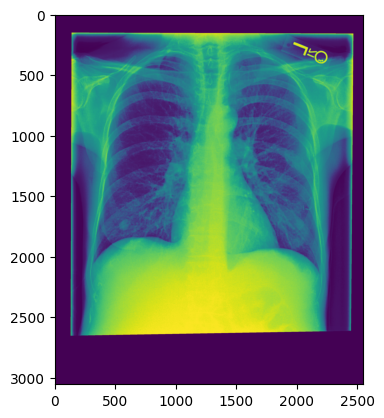

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

SUBJECT_ID = "10000032"
SUBJECT_PREFIX = SUBJECT_ID[:2]
STUDY_ID = "50414267"  # All images in the same study will have the same ID, as they are just different views of the same study
DICOM_ID = "02aa804e-bde0afdd-112c0b34-7bc16630-4e384014"

EXAMPLE_IMG_DIR = f"/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files/p{SUBJECT_PREFIX}/p{SUBJECT_ID}/s{STUDY_ID}/{DICOM_ID}.jpg"
img = mpimg.imread(EXAMPLE_IMG_DIR)
imgplot = plt.imshow(img)

In [ ]:
from datasets import Dataset, Image, Features, ClassLabel, Sequence
import pandas as pd
import os
from pathlib import Path
import numpy as np
import dataclasses


MIMIC_CXR_FILES_DIR_NAME_PATTERN = "p1[0-9]"
MIMIC_CXR_PATIENT_DIR_NAME_PATTERN = "p*"
MIMIC_CXR_STUDY_DIR_NAME_PATTERN = "s*"
MIMIC_CXR_DATASET_ROOT_DIR = "/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files"
MIMIC_CXR_SPLIT_CSV_PATH = "/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-split.csv"
MIMIC_CXR_FINDINGS_CSV_PATH = (
    "/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv"
)

In [ ]:
@dataclasses.dataclass
class MimicCxrRelativeImgPath:
    subject_id: str
    study_id: str
    dicom_id: str

    @property
    def relative_img_path(self) -> str:
        subject_prefix = str(self.subject_id)[:2]
        return os.path.join(
            f"p{subject_prefix}",
            f"p{self.subject_id}",
            f"s{self.study_id}",
            f"{self.dicom_id}.jpg",
        )


def _aggregate_and_sort_split_and_findings_information(
    split_df: pd.DataFrame, findings_df: pd.DataFrame
) -> pd.DataFrame:
    merged_df = pd.merge(findings_df, split_df, on=["subject_id", "study_id"], how="inner")
    merged_df = merged_df.sort_values(["subject_id", "study_id"])
    return merged_df


def _resolve_img_path(mimic_cxr_df: pd.DataFrame) -> pd.DataFrame:
    mimic_cxr_df = mimic_cxr_df.copy()
    mimic_cxr_df["img_path"] = mimic_cxr_df.apply(
        lambda row: os.path.join(
            MIMIC_CXR_DATASET_ROOT_DIR,
            MimicCxrRelativeImgPath(
                subject_id=row["subject_id"], study_id=row["study_id"], dicom_id=row["dicom_id"]
            ).relative_img_path,
        ),
        axis=1,
    )
    return mimic_cxr_df


def create_dataset(
    mimic_cxr_dataset_root_dir: str = MIMIC_CXR_DATASET_ROOT_DIR,
    mimic_cxr_split_csv_path: str = MIMIC_CXR_SPLIT_CSV_PATH,
    mimic_cxr_findings_csv_path: str = MIMIC_CXR_FINDINGS_CSV_PATH,
):
    """
    Create a Hugging Face dataset from the X-ray images and their labels
    Using an optimized directory traversal approach
    """

    split_df = pd.read_csv(mimic_cxr_split_csv_path)
    findings_df = pd.read_csv(mimic_cxr_findings_csv_path)
    findings_and_split_df = _aggregate_and_sort_split_and_findings_information(
        split_df, findings_df
    )
    findings_and_split_df = _resolve_img_path(findings_and_split_df)

    return findings_and_split_df

In [ ]:
create_dataset()["img_path"][0]

'/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg'

In [ ]:
def _get_patient_and_study_directories(mimic_cxr_dataset_root_dir: str) -> list[tuple[str, str]]:
    # This function can take quite some minutes to run, as it needs to traverse the entire dataset directory
    root_path = Path(mimic_cxr_dataset_root_dir)
    patient_study_dir_list = []
    for p_dir in sorted(root_path.glob(MIMIC_CXR_FILES_DIR_NAME_PATTERN)):
        for patient_dir in sorted(p_dir.glob(MIMIC_CXR_PATIENT_DIR_NAME_PATTERN)):
            for study_dir in sorted(patient_dir.glob(MIMIC_CXR_STUDY_DIR_NAME_PATTERN)):
                patient_id = patient_dir.name
                study_id = study_dir.name
                patient_study_dir_list.append((patient_id, study_id))
    return patient_study_dir_list


def test_get_patient_and_study_directories():
    # This test will take a few minutes to run
    patient_study_dir_list = _get_patient_and_study_directories(
        mimic_cxr_dataset_root_dir=MIMIC_CXR_DATASET_ROOT_DIR
    )
    assert len(patient_study_dir_list) == 227835
    assert patient_study_dir_list[0] == ("p10000032", "s50414267")
    assert patient_study_dir_list[-1] == ("p19999733", "s57132437")


test_get_patient_and_study_directories()

In [ ]:
def create_dataset(root_dir, split_csv, findings_csv):
    """
    Create a Hugging Face dataset from the X-ray images and their labels
    """

    split_df = pd.read_csv(split_csv)
    findings_df = pd.read_csv(findings_csv)

    # Initialize lists to store our data
    data = {
        "image_path": [],
        "patient_id": [],
        "study_id": [],
        "split": [],
        "labels": [],  # Will contain the 14 binary indicators
    }

    # Walk through the directory structure
    for p_dir in root_path.glob("p1[0-9]"):
        print(p_dir)
        for patient_dir in p_dir.glob("p*"):
            print(patient_dir)
            for study_dir in patient_dir.glob("s*"):
                print(study_dir)
                return
                patient_id = patient_dir.name
                study_id = study_dir.name

                # Get split information
                split_info = split_df[
                    (split_df["patient_id"] == patient_id) & (split_df["study_id"] == study_id)
                ]

                if split_info.empty:
                    continue

                # Get findings for this study
                findings = findings_df[
                    (findings_df["patient_id"] == patient_id)
                    & (findings_df["study_id"] == study_id)
                ]

                if findings.empty:
                    continue

                # Get labels (assuming binary indicators start from column 3)
                labels = findings.iloc[0, 2:].values.astype(np.float32)

                # Add all images for this study
                for img_path in study_dir.glob("*.jpg"):
                    data["image_path"].append(str(img_path))
                    data["patient_id"].append(patient_id)
                    data["study_id"].append(study_id)
                    data["split"].append(split_info.iloc[0]["split"])
                    data["labels"].append(labels)

    # Create the dataset
    dataset = Dataset.from_dict(data)
    return dataset

    # Set the format to handle images
    dataset = dataset.cast_column("image_path", Image())

    # Split the dataset
    dataset = dataset.train_test_split(train_test_split=0.8, stratify_by_column="split")

    # Further split train into train and validation
    train_val = dataset["train"].train_test_split(train_test_split=0.9, stratify_by_column="split")

    # Create the final dataset dictionary
    dataset_dict = {
        "train": train_val["train"],
        "validation": train_val["test"],
        "test": dataset["test"],
    }

    return dataset_dict

In [ ]:
dataset = create_dataset(
    root_dir="/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files",
    split_csv="/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-split.csv",
    findings_csv="/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.csv",
)

/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files/p16
/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files/p16/p16255488
/home/data/DIVA/mimic/mimic-cxr-jpg/2.0.0/files/p16/p16255488/s58814178


In [ ]:
dataset

Dataset({
    features: ['image_path', 'patient_id', 'study_id', 'split', 'labels'],
    num_rows: 0
})